# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 8: Radiative Equilibrium

____________
<a id='section1'></a>

## 1. The observed annual, global mean temperature profile
____________

Let's look again the observations of air temperature from the NCEP Reanalysis data.

This just repeats what we did in the notebook `L06_Radiation.ipynb`. Refer back there for more details.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
import climlab
from metpy.plots import SkewT

In [2]:
# This will try to read the data over the internet.
temperature_filename = 'air.mon.1981-2010.ltm.nc'  # temperature
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
#  Open handle to data
ncep_air = xr.open_dataset(ncep_url + temperature_filename, decode_times=False)

In [3]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
print( Tglobal)

<xarray.DataArray (level: 17)>
array([ 15.179082,  11.207002,   7.838327,   0.219941,  -6.448343, -14.888844,
       -25.570467, -39.369685, -46.797908, -53.652235, -60.563551, -67.006048,
       -65.532927, -61.486637, -55.853581, -51.593945, -43.219982])
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 600.0 500.0 400.0 ...


As we did before, we're going to plot these data on a "Skew-T" diagram. 

Here we'll make a function to create the diagram, because later we are going to reuse it several times.

In [4]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

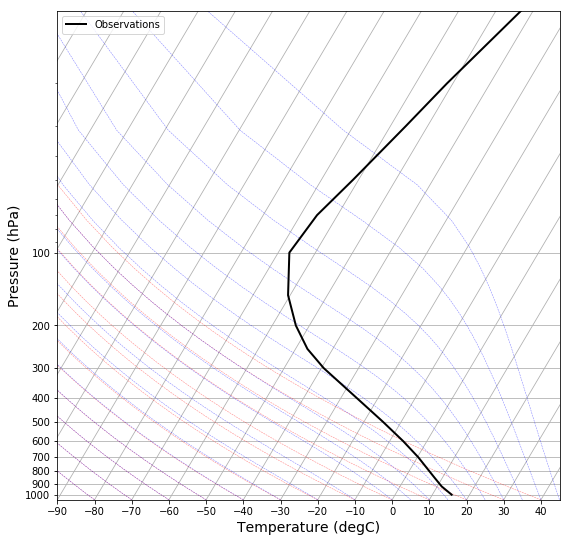

In [5]:
skew = make_skewT()

We are now going to work on some single-column models of the vertical temperature profile to understand physical factors determining the observed profile.

____________
<a id='section2'></a>

## 2. Radiative equilibrium -- the concept
____________

Models of radiative transfer slice up the atmospheric air column into a series of layer, and calculate the **emission** and **absorption** of radiation within each layer.

It's really just a generalization of the model we already looked at:

![Sketch of layer model](http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/2layerAtm_sketch.png)

The concept of **radiative equilibrium** means that we **ignore all methods of heat exchange except for radiation**, and ask what temperature profile would exist under that assumption?

We can answer that question by using a radiative transfer model to explicity compute the shortwave and longwave beams, and the warming/cooling of each layer associated with the radiative sources and sinks of energy.

Basically, we reach radiative equilibrium when **energy is received and lost through radiation at the same rate in every layer**.

Because of the complicated dependence of emission/absorption features on the wavelength of radiation and the different gases, the beam is divided up into many different pieces representing different parts of the electromagnetic spectrum.

We will not look explicitly at this complexity here, but we will **use a model** that represents these processes at the same level of detail we would in a GCM.

____________
<a id='section3'></a>

## 3. Pure radiative equilibrium in the RRTMG model
____________

We're going to use a model called the [Rapid Radiative Transfer Model](http://rtweb.aer.com/rrtm_frame.html) or RRTMG. This is a "serious" and widely-used radiation model, used in many comprehensive GCMs and Numerical Weather Prediction models.

`climlab` provides an easy-to-use Python wrapper for the RRTMG code.

### Water vapor data

Before setting up the model, we need some water vapor data.

We're actually going to use the specific humidity field from our CESM control simulation:

In [6]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

Take global, annual average of the specific humidity:

In [7]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))
Qglobal

<xarray.DataArray (lev: 26)>
array([  2.162550e-06,   2.159117e-06,   2.149430e-06,   2.133799e-06,
         2.119934e-06,   2.111498e-06,   2.095464e-06,   2.118271e-06,
         2.441435e-06,   3.155951e-06,   5.057482e-06,   9.663076e-06,
         2.100241e-05,   4.803590e-05,   1.056113e-04,   2.117998e-04,
         3.935585e-04,   7.106597e-04,   1.340892e-03,   2.050905e-03,
         3.162419e-03,   4.961048e-03,   6.608193e-03,   8.364253e-03,
         9.364700e-03,   9.629375e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 37.23 53.11 70.06 85.44 ...

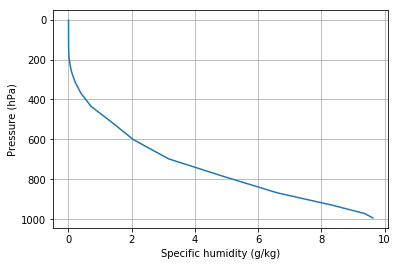

In [8]:
fig, ax = plt.subplots()
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)')
ax.grid()

### Create a single-column model on the same grid as this water vapor data:

In [9]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
state

{'Tatm': Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
         221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
         243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
         265.52,  268.64,  271.76,  274.88,  278.  ]), 'Ts': Field([ 288.])}

In [10]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,
                             )
print(radmodel)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiation (all gases): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



Look at a few interesting properties of the model we just created:

In [11]:
#  Here's the state dictionary we already created:
radmodel.state

{'Tatm': Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
         221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
         243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
         265.52,  268.64,  271.76,  274.88,  278.  ]), 'Ts': Field([ 288.])}

In [12]:
#  Here are the pressure levels in hPa
radmodel.lev

array([   3.544638 ,    7.3888135,   13.967214 ,   23.944625 ,
         37.23029  ,   53.114605 ,   70.05915  ,   85.439115 ,
        100.514695 ,  118.250335 ,  139.115395 ,  163.66207  ,
        192.539935 ,  226.513265 ,  266.481155 ,  313.501265 ,
        368.81798  ,  433.895225 ,  510.455255 ,  600.5242   ,
        696.79629  ,  787.70206  ,  867.16076  ,  929.648875 ,
        970.55483  ,  992.5561   ])

There is a dictionary called `absorber_vmr` that holds the *volume mixing ratio* of all the radiatively active gases in the column"

In [13]:
radmodel.absorber_vmr

{'CCL4': 0.0,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CH4': 1.65e-06,
 'CO2': 0.000348,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'O3': array([  7.52507018e-06,   8.51545793e-06,   7.87041289e-06,
          5.59601020e-06,   3.46128454e-06,   2.02820936e-06,
          1.13263102e-06,   7.30182697e-07,   5.27326553e-07,
          3.83940962e-07,   2.82227214e-07,   2.12188506e-07,
          1.62569291e-07,   1.17991442e-07,   8.23582543e-08,
          6.25738219e-08,   5.34457156e-08,   4.72688637e-08,
          4.23614749e-08,   3.91392482e-08,   3.56025264e-08,
          3.12026770e-08,   2.73165152e-08,   2.47190016e-08,
          2.30518624e-08,   2.22005071e-08])}

Most are just a single number because they are assumed to be **well mixed** in the atmosphere.

The exception is ozone, which has a vertical structure taken from observations. Let's plot it

### Python exercise

Make a simple plot showing the vertical structure of ozone

In [14]:
# here is the data you need for the plot, as a plain numpy arrays:
print(radmodel.lev)
print(radmodel.absorber_vmr['O3'])

[   3.544638     7.3888135   13.967214    23.944625    37.23029     53.114605
   70.05915     85.439115   100.514695   118.250335   139.115395   163.66207
  192.539935   226.513265   266.481155   313.501265   368.81798    433.895225
  510.455255   600.5242     696.79629    787.70206    867.16076    929.648875
  970.55483    992.5561   ]
[  7.52507018e-06   8.51545793e-06   7.87041289e-06   5.59601020e-06
   3.46128454e-06   2.02820936e-06   1.13263102e-06   7.30182697e-07
   5.27326553e-07   3.83940962e-07   2.82227214e-07   2.12188506e-07
   1.62569291e-07   1.17991442e-07   8.23582543e-08   6.25738219e-08
   5.34457156e-08   4.72688637e-08   4.23614749e-08   3.91392482e-08
   3.56025264e-08   3.12026770e-08   2.73165152e-08   2.47190016e-08
   2.30518624e-08   2.22005071e-08]


The other radiatively important gas is of course water vapor, which is stored separately in the `specific_humidity` attribute:

In [15]:
#  specific humidity in kg/kg, on the same pressure axis
radmodel.specific_humidity

array([  2.16255006e-06,   2.15911701e-06,   2.14943023e-06,
         2.13379934e-06,   2.11993381e-06,   2.11149790e-06,
         2.09546420e-06,   2.11827126e-06,   2.44143531e-06,
         3.15595114e-06,   5.05748229e-06,   9.66307595e-06,
         2.10024053e-05,   4.80359029e-05,   1.05611312e-04,
         2.11799800e-04,   3.93558531e-04,   7.10659654e-04,
         1.34089154e-03,   2.05090474e-03,   3.16241947e-03,
         4.96104823e-03,   6.60819328e-03,   8.36425275e-03,
         9.36470014e-03,   9.62937462e-03])

### Step the model forward in time!

In [16]:
radmodel.Ts

Field([ 288.])

In [17]:
radmodel.Tatm

Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
        221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
        243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
        265.52,  268.64,  271.76,  274.88,  278.  ])

Now let's take a single timestep:

In [18]:
radmodel.step_forward()

In [19]:
radmodel.Ts

Field([ 288.5764762])

The surface got warmer! 

Let's take a look at all the diagnostic information that was generated during that timestep:

Every `climlab` model has a `diagnostics` dictionary. Here we are going to check it out as an `xarray` dataset:

In [20]:
climlab.to_xarray(radmodel.diagnostics)

<xarray.Dataset>
Dimensions:           (depth: 1, depth_bounds: 2, lev: 26, lev_bounds: 27)
Coordinates:
  * depth             (depth) float64 1.25
  * depth_bounds      (depth_bounds) float64 0.0 2.5
  * lev               (lev) float64 3.545 7.389 13.97 23.94 37.23 53.11 ...
  * lev_bounds        (lev_bounds) float64 0.0 5.467 10.68 18.96 30.59 45.17 ...
Data variables:
    OLR               (depth) float64 251.0
    OLRclr            (depth) float64 251.0
    OLRcld            (depth) float64 0.0
    TdotLW            (lev) float64 -1.505 -0.8463 -0.8032 -0.6716 -0.5765 ...
    TdotLW_clr        (lev) float64 -1.505 -0.8463 -0.8032 -0.6716 -0.5765 ...
    LW_sfc            (depth) float64 94.05
    LW_sfc_clr        (depth) float64 94.05
    LW_flux_up        (lev_bounds) float64 251.0 251.3 251.7 252.4 253.5 ...
    LW_flux_down      (lev_bounds) float64 0.0 1.214 2.106 3.634 5.697 8.138 ...
    LW_flux_net       (lev_bounds) float64 251.0 250.1 249.5 248.8 247.8 ...
    LW_flux_up_

The main "job" of a radiative transfer model it to calculate the shortwave and longwave fluxes up and down between each model layer.

For example:

In [21]:
climlab.to_xarray(radmodel.LW_flux_up)

<xarray.DataArray (lev_bounds: 27)>
array([ 251.047159,  251.285711,  251.654273,  252.393846,  253.530432,
        254.974513,  256.54334 ,  257.984705,  259.266985,  260.588415,
        262.004427,  263.549501,  265.279088,  267.265231,  269.657799,
        272.60065 ,  276.201332,  280.493681,  285.597399,  291.930843,
        299.424326,  308.286012,  319.22169 ,  331.845081,  346.026836,
        360.387137,  390.099018])
Coordinates:
  * lev_bounds  (lev_bounds) float64 0.0 5.467 10.68 18.96 30.59 45.17 61.59 ...

These are upward longwave fluxes in W/m2.

Why are there 27 data points, when the model has 26 pressure levels?

In [22]:
radmodel.lev

array([   3.544638 ,    7.3888135,   13.967214 ,   23.944625 ,
         37.23029  ,   53.114605 ,   70.05915  ,   85.439115 ,
        100.514695 ,  118.250335 ,  139.115395 ,  163.66207  ,
        192.539935 ,  226.513265 ,  266.481155 ,  313.501265 ,
        368.81798  ,  433.895225 ,  510.455255 ,  600.5242   ,
        696.79629  ,  787.70206  ,  867.16076  ,  929.648875 ,
        970.55483  ,  992.5561   ])

In [23]:
radmodel.lev_bounds

array([    0.        ,     5.46672575,    10.67801375,    18.9559195 ,
          30.5874575 ,    45.1724475 ,    61.5868775 ,    77.7491325 ,
          92.976905  ,   109.382515  ,   128.682865  ,   151.3887325 ,
         178.1010025 ,   209.5266    ,   246.49721   ,   289.99121   ,
         341.1596225 ,   401.3566025 ,   472.17524   ,   555.4897275 ,
         648.660245  ,   742.249175  ,   827.43141   ,   898.4048175 ,
         950.1018525 ,   981.555465  ,  1000.        ])

The last element of the flux array represents the **upward flux from the surface to the first level**:

In [24]:
radmodel.LW_flux_up[-1]

390.09901849147116

The value is about 390 W m$^{-2}$. 

Why?

In [25]:
sigma = 5.67E-8
sigma * 288**4

390.0793946112

The surface temperature was initialized at 288 K, and the surface is treated as very close to a blackbody in the model.

What about the flux from the top layer out to space?

Two ways to access this information:

In [26]:
radmodel.LW_flux_up[0]

251.04715901472403

In [27]:
radmodel.OLR

Field([ 251.04715901])

Of course there is a whole other set of fluxes for the shortwave radiation.

One diagnostic we will often want to look at is the **net energy budget at the top of the atmosphere**:

In [28]:
radmodel.ASR - radmodel.OLR

Field([ 3.72695577])

Is the model gaining or losing energy?

### Integrate out to equilibrium

In [29]:
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()

Check the energy budget again:

In [30]:
#  Check the energy budget again
radmodel.ASR - radmodel.OLR

Field([ 0.00990126])

### Compare the radiative equilibrium temperature to observations

Here's a helper function we'll use to add model temperature profiles to our skew-T plot:

In [31]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

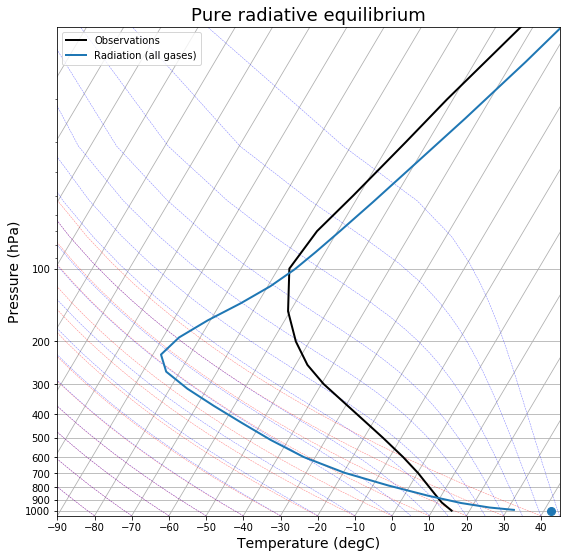

In [32]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

What do you think about this model -- data comparison?

____________
<a id='section4'></a>

## 4. Effects of different gases on the radiative equilibrium profile
____________

Models are for experimenting and playing with!

We have just built a single-column radiation model with several different absorbing gases. We can learn about their effects by taking them away.

In [33]:
# Make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
radmodel_noH2O.name = 'Radiation (no H2O)'
print(radmodel_noH2O)

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiation (no H2O): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



In [34]:
#  Here is the water vapor profile we started with
radmodel_noH2O.specific_humidity

array([  2.16255006e-06,   2.15911701e-06,   2.14943023e-06,
         2.13379934e-06,   2.11993381e-06,   2.11149790e-06,
         2.09546420e-06,   2.11827126e-06,   2.44143531e-06,
         3.15595114e-06,   5.05748229e-06,   9.66307595e-06,
         2.10024053e-05,   4.80359029e-05,   1.05611312e-04,
         2.11799800e-04,   3.93558531e-04,   7.10659654e-04,
         1.34089154e-03,   2.05090474e-03,   3.16241947e-03,
         4.96104823e-03,   6.60819328e-03,   8.36425275e-03,
         9.36470014e-03,   9.62937462e-03])

Now get rid of the water entirely!

In [35]:
radmodel_noH2O.specific_humidity *= 0.

In [36]:
radmodel_noH2O.specific_humidity

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [37]:
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

In [38]:
radmodel_noH2O.ASR - radmodel_noH2O.OLR

Field([-0.00998947])

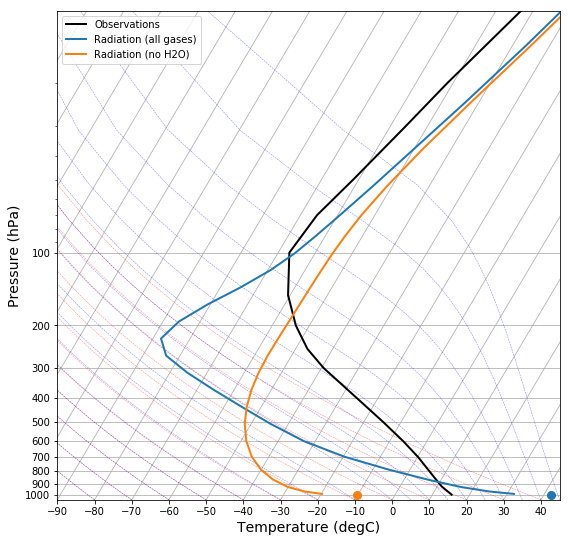

In [39]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

What do you think you can learn from this about the radiative role of water vapor?

### Exercise

Following the steps above, make another model, but this time instead of removing the water vapor, remove the ozone!

Make another skew-T plot comparing all three model results.

____________
<a id='section5'></a>

## 5. Summary of radiative equilibrium results
____________

- We used the `RRTMG` radiation model with prescribed profiles of absorbing gases to calculate **pure radiative equilibrium** temperature profiles.
- Radiative Equilibriu means the temperatures that the surface and air column would have **if radiation was the only physical process that could transfer energy between levels**.
- We computed several different radiative equilibrium profiles, with and without key absorbing gases
    - The profile without water vapor is **much colder at surface and lower troposphere**, but about the same in the stratosphere
    - The profile without ozone is **much colder in the stratosphere**, but about the same near the surface.
    - In fact there really isn't a stratosphere at all without ozone! The temperature is nearly isothermal in the upper atmosphere in that profile.

However the really key takeaway message is that **none of these radiative equilibrium profiles look much like the observations in the troposphere**.

This strongly suggests that other physical processes (aside from radiation) are important in determining the observed temperature profile.

Plotting on the skew-T diagram makes it clear that **all the radiative equilibrium profiles are statically unstable near the surface**.

The next step is therefore to look at the effects of convective mixing on the temperatures of the surface and lower troposphere.